# Carica i dati

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.2")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .getOrCreate()

plots_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()\
    .select('_id', 'title', 'genres', 'overview', 'vote_average')
plots_df = plots_df.rdd.filter(lambda x: x).toDF()
plots_df.show()

+-----+--------------------+-------------------+--------------------+------------+
|  _id|               title|             genres|            overview|vote_average|
+-----+--------------------+-------------------+--------------------+------------+
|  862|           Toy Story|    [16, 35, 10751]|Led by Woody, And...|         7.7|
| 8844|             Jumanji|    [12, 14, 10751]|When siblings Jud...|         6.9|
|15602|    Grumpier Old Men|        [10749, 35]|A family wedding ...|         6.5|
|31357|   Waiting to Exhale|    [35, 18, 10749]|Cheated on, mistr...|         6.1|
|11862|Father of the Bri...|               [35]|Just when George ...|         5.7|
|  949|                Heat|   [28, 80, 18, 53]|Obsessive master ...|         7.7|
|11860|             Sabrina|        [35, 10749]|An ugly duckling ...|         6.2|
|45325|        Tom and Huck|[28, 12, 18, 10751]|A mischievous you...|         5.4|
| 9091|        Sudden Death|       [28, 12, 53]|International act...|         5.5|
|  7

In [2]:
spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.genres") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.genres") \
    .getOrCreate()
genres = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

genres.show(32)

+-----+--------------------+
|  _id|                name|
+-----+--------------------+
|   16|           Animation|
|   35|              Comedy|
|10751|              Family|
|   12|           Adventure|
|   14|             Fantasy|
|10749|             Romance|
|   18|               Drama|
|   28|              Action|
|   80|               Crime|
|   53|            Thriller|
|   27|              Horror|
|   36|             History|
|  878|     Science Fiction|
| 9648|             Mystery|
|10752|                 War|
|10769|             Foreign|
|10402|               Music|
|   99|         Documentary|
|   37|             Western|
|10770|            TV Movie|
|11176|Carousel Productions|
|11602|Vision View Enter...|
|29812|Telescene Film Gr...|
| 2883|             Aniplex|
| 7759|             GoHands|
| 7760|           BROSTA TV|
| 7761|Mardock Scramble ...|
|33751|    Sentai Filmworks|
|17161|       Odyssey Media|
|18012|  Pulser Productions|
|18013|         Rogue State|
|23822|       

# Corrispondenza trama-genere

In [3]:
ordered_genres = genres.rdd\
    .map(lambda x: (x._id, x.name))\
    .collect()

reorder = {}
for i in range(len(ordered_genres)):
    reorder[ordered_genres[i][0]] = i

genres_new_order = {}
for g in ordered_genres:
    genres_new_order[g[1]] = reorder[g[0]]

genres_new_order

{'Animation': 0,
 'Comedy': 1,
 'Family': 2,
 'Adventure': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'History': 11,
 'Science Fiction': 12,
 'Mystery': 13,
 'War': 14,
 'Foreign': 15,
 'Music': 16,
 'Documentary': 17,
 'Western': 18,
 'TV Movie': 19,
 'Carousel Productions': 20,
 'Vision View Entertainment': 21,
 'Telescene Film Group Productions': 22,
 'Aniplex': 23,
 'GoHands': 24,
 'BROSTA TV': 25,
 'Mardock Scramble Production Committee': 26,
 'Sentai Filmworks': 27,
 'Odyssey Media': 28,
 'Pulser Productions': 29,
 'Rogue State': 30,
 'The Cartel': 31}

In [4]:
id_genres = plots_df.rdd\
    .filter(lambda x: x[2])\
    .map(lambda x: (x[0], x[1], reorder[x[2][0]], x[3], x[4]))\
    .toDF(['id', 'title', 'genre', 'overview', 'vote'])

id_genres.show()

+-----+--------------------+-----+--------------------+----+
|   id|               title|genre|            overview|vote|
+-----+--------------------+-----+--------------------+----+
|  862|           Toy Story|    0|Led by Woody, And...| 7.7|
| 8844|             Jumanji|    3|When siblings Jud...| 6.9|
|15602|    Grumpier Old Men|    5|A family wedding ...| 6.5|
|31357|   Waiting to Exhale|    1|Cheated on, mistr...| 6.1|
|11862|Father of the Bri...|    1|Just when George ...| 5.7|
|  949|                Heat|    7|Obsessive master ...| 7.7|
|11860|             Sabrina|    1|An ugly duckling ...| 6.2|
|45325|        Tom and Huck|    7|A mischievous you...| 5.4|
| 9091|        Sudden Death|    7|International act...| 5.5|
|  710|           GoldenEye|    3|James Bond must u...| 6.6|
| 9087|The American Pres...|    1|Widowed U.S. pres...| 6.5|
|12110|Dracula: Dead and...|    1|When a lawyer sho...| 5.7|
|21032|               Balto|    2|An outcast half-w...| 7.1|
|10858|               Ni

In [5]:
genres_training = id_genres.sample(False, 0.9, 0)
genres_test = id_genres.subtract(genres_training)
print('Training size:', genres_training.count())
print('Test size:', genres_test.count())
genres_training.show()

Training size: 38713
Test size: 4278
+-----+--------------------+-----+--------------------+----+
|   id|               title|genre|            overview|vote|
+-----+--------------------+-----+--------------------+----+
|  862|           Toy Story|    0|Led by Woody, And...| 7.7|
| 8844|             Jumanji|    3|When siblings Jud...| 6.9|
|15602|    Grumpier Old Men|    5|A family wedding ...| 6.5|
|31357|   Waiting to Exhale|    1|Cheated on, mistr...| 6.1|
|11862|Father of the Bri...|    1|Just when George ...| 5.7|
|11860|             Sabrina|    1|An ugly duckling ...| 6.2|
|45325|        Tom and Huck|    7|A mischievous you...| 5.4|
| 9091|        Sudden Death|    7|International act...| 5.5|
|  710|           GoldenEye|    3|James Bond must u...| 6.6|
| 9087|The American Pres...|    1|Widowed U.S. pres...| 6.5|
|12110|Dracula: Dead and...|    1|When a lawyer sho...| 5.7|
|21032|               Balto|    2|An outcast half-w...| 7.1|
|10858|               Nixon|   11|An all-star ca

# Trova le parole più usate

In [6]:
stopwords = set()
for line in open('stopwords.txt'):
    stopwords.add(line.strip())
stopwords

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'away',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'computer',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fify',
 'fill',
 'find',
 'fire',
 'fi

In [7]:
mapped = genres_training.rdd\
    .map(lambda x: x.overview.replace(',', ' ').replace('.', ' ').replace('-', ' ')\
    .replace('"', ' ').replace('*', ' ').replace('(', ' ').replace(')', ' ')\
    .replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ')\
    .replace(':', ' ').replace(';', ' ').replace('$', ' ').replace('=', ' ').lower())\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: len(x) > 2)\
    .map(lambda x: (x.strip(), 1))\
    .filter(lambda x: x[0] not in stopwords)

occurrences = mapped.reduceByKey(lambda x, y: x + y).collect()
occurrences.sort(key=lambda x: x[1], reverse=True)
occurrences

[('life', 6617),
 ('young', 5591),
 ('new', 4891),
 ('film', 4737),
 ('man', 4552),
 ('love', 4336),
 ('story', 3875),
 ('family', 3812),
 ('world', 3800),
 ('old', 3318),
 ('time', 3076),
 ('woman', 2925),
 ('years', 2924),
 ('father', 2534),
 ('finds', 2462),
 ('war', 2407),
 ('year', 2376),
 ('wife', 2327),
 ('girl', 2257),
 ('lives', 2251),
 ('friends', 2240),
 ('home', 2220),
 ('town', 2206),
 ('day', 2093),
 ('way', 2085),
 ('school', 2042),
 ('help', 2007),
 ('takes', 1991),
 ('people', 1923),
 ('mother', 1896),
 ('son', 1867),
 ('death', 1820),
 ('soon', 1807),
 ('daughter', 1799),
 ('friend', 1765),
 ('group', 1759),
 ('make', 1749),
 ('city', 1727),
 ('set', 1692),
 ('gets', 1687),
 ('american', 1629),
 ('small', 1616),
 ('men', 1518),
 ('meets', 1492),
 ('high', 1465),
 ('night', 1440),
 ('house', 1435),
 ('begins', 1423),
 ('police', 1412),
 ('falls', 1384),
 ('work', 1384),
 ('like', 1367),
 ('goes', 1364),
 ('best', 1350),
 ('documentary', 1330),
 ('boy', 1309),
 ('husban

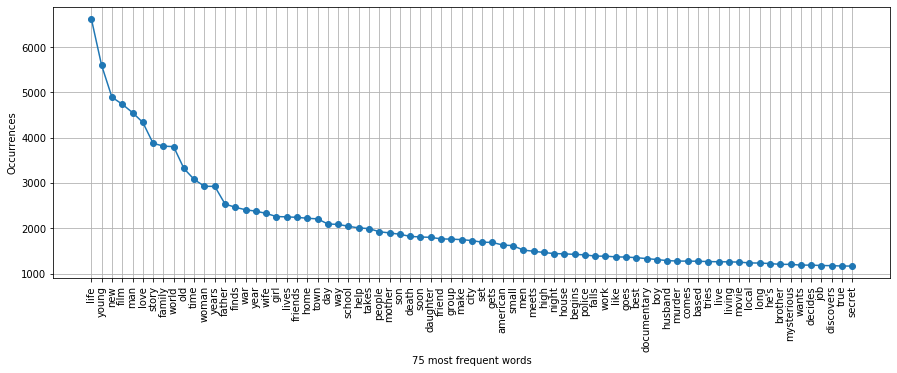

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([x[0] for x in occurrences[:75]], [x[1] for x in occurrences[:75]], marker='o')
plt.xticks(rotation=90)
plt.xlabel('75 most frequent words')
plt.ylabel('Occurrences')
plt.show()

## Vocabolario da 1000 parole

In [9]:
n_words = 1000

vocabulary = [occurrences[x][0] for x in range(n_words)]
vocabulary.sort()

vocabulary_dict = {}
i = 0
for word in vocabulary:
    vocabulary_dict[word] = i
    i += 1

vocabulary_dict

{'&amp': 0,
 '000': 1,
 'abandoned': 2,
 'able': 3,
 'academy': 4,
 'accident': 5,
 'accidentally': 6,
 'accused': 7,
 'act': 8,
 'action': 9,
 'actor': 10,
 'actress': 11,
 'actually': 12,
 'adventure': 13,
 'adventures': 14,
 'affair': 15,
 'african': 16,
 'age': 17,
 'aged': 18,
 'agent': 19,
 'ago': 20,
 'agrees': 21,
 'air': 22,
 'alex': 23,
 'alice': 24,
 'alien': 25,
 'alive': 26,
 'america': 27,
 'american': 28,
 'ancient': 29,
 'angeles': 30,
 'animated': 31,
 'anna': 32,
 'apart': 33,
 'apartment': 34,
 'appears': 35,
 'area': 36,
 'army': 37,
 'arrival': 38,
 'arrive': 39,
 'arrives': 40,
 'art': 41,
 'artist': 42,
 'arts': 43,
 'asks': 44,
 'assigned': 45,
 'assistant': 46,
 'attack': 47,
 'attempt': 48,
 'attempts': 49,
 'attention': 50,
 'author': 51,
 'award': 52,
 'baby': 53,
 'bad': 54,
 'band': 55,
 'bank': 56,
 'bar': 57,
 'based': 58,
 'battle': 59,
 'beach': 60,
 'beautiful': 61,
 'beauty': 62,
 'begin': 63,
 'beginning': 64,
 'begins': 65,
 'believe': 66,
 'believ

# Trasformazione dei dati nel formato adatto

In [10]:
from pyspark.ml.linalg import Vectors

def dict_func(x, y):
    z = dict()
    z.update(x)
    z.update(y)
    return z

def featurisation(x):
    occ_dict = {}
    plot_terms = x[1]
    for term in plot_terms:
        occ_dict[vocabulary_dict[term]] = plot_terms[term]
    return (int(x[0]), Vectors.sparse(n_words, occ_dict))

counted_rdd = genres_training.rdd\
    .map(lambda x: (x.id, x.overview))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ')\
    .replace('"', ' ').replace('*', ' ').replace('(', ' ').replace(')', ' ')\
    .replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ')\
    .replace(':', ' ').replace(';', ' ').replace('$', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

features_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary_dict)\
    .map(lambda x: (x[0].split('.')[0], {x[0].split('.')[1]: x[1]}))\
    .filter(lambda x: type(x[1]) is dict and type(x) is not None)\
    .reduceByKey(dict_func).map(featurisation)

spark = SparkSession.builder.appName('Words DF').getOrCreate()
vocab_words_tr = spark.createDataFrame(features_rdd, ['feat_id', 'features'])


counted_rdd = genres_test.rdd\
    .map(lambda x: (x.id, x.overview))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ')\
    .replace('"', ' ').replace('*', ' ').replace('(', ' ').replace(')', ' ')\
    .replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ')\
    .replace(':', ' ').replace(';', ' ').replace('$', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

features_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary_dict)\
    .map(lambda x: (x[0].split('.')[0], {x[0].split('.')[1]: x[1]}))\
    .filter(lambda x: type(x[1]) is dict and type(x) is not None)\
    .reduceByKey(dict_func).map(featurisation)

spark = SparkSession.builder.appName('Words DF').getOrCreate()
vocab_words_te = spark.createDataFrame(features_rdd, ['feat_id', 'features'])

print(vocab_words_tr.count())
print(vocab_words_te.count())
vocab_words_tr.show()

38497
4264
+-------+--------------------+
|feat_id|            features|
+-------+--------------------+
|    862|(1000,[93,268,393...|
|   8844|(1000,[218,230,27...|
|  15602|(1000,[29,230,288...|
|  31357|(1000,[71,90,208,...|
|  11862|(1000,[38,124,350...|
|  11860|(1000,[95,101,124...|
|  45325|(1000,[7,14,87,19...|
|   9091|(1000,[9,191,250,...|
|    710|(1000,[82,391,452...|
|   9087|(1000,[49,564,672...|
|  12110|(1000,[3,79,255,2...|
|  21032|(1000,[196,378,50...|
|  10858|(1000,[28,103,116...|
|   1408|(1000,[94,159,178...|
|    524|(1000,[190,505],[...|
|   4584|(1000,[213,497,66...|
|      5|(1000,[447,459,61...|
|   9273|(1000,[319,466,57...|
|  11517|(1000,[95,166,200...|
|   8012|(1000,[54,86,214,...|
+-------+--------------------+
only showing top 20 rows



# Divisione tra training e test

In [11]:
training_gs = vocab_words_tr.join(id_genres, vocab_words_tr.feat_id == id_genres.id)\
    .select('genre', 'features').toDF('label', 'features')

test_gs = vocab_words_te.join(id_genres, vocab_words_te.feat_id == id_genres.id)\
    .select('genre', 'features').toDF('label', 'features')

print(training_gs.count())
print(test_gs.count())

38497
4264


# Test naive Bayes

In [12]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType='multinomial')
model = nb.fit(training_gs)
nb_predictions = model.transform(test_gs)

n_observations = nb_predictions.rdd.count()
right = nb_predictions.rdd\
    .map(lambda x: x[0] - int(x[4]))\
    .filter(lambda x: x == 0)\
    .count()
accuracy = (right / n_observations) * 100

print('Accuracy:', accuracy)
nb_predictions.show()

Accuracy: 42.21388367729831
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    6|(1000,[3,77,85,15...|[-179.26267316428...|[1.01990036089460...|       1.0|
|    5|(1000,[114,128,18...|[-318.61093134086...|[3.11602494786298...|       1.0|
|    7|(1000,[13,72,150,...|[-148.45637105118...|[0.00190105040045...|       3.0|
|    1|(1000,[126,191,36...|[-237.98952000191...|[1.35453093682920...|       1.0|
|   10|(1000,[28,97,152,...|[-121.86318693323...|[1.21686628631513...|      10.0|
|    9|(1000,[263,423],[...|[-21.128547114353...|[5.39687837321408...|       6.0|
|   17|(1000,[9,16,70,12...|[-182.33625860476...|[1.38613774882980...|       7.0|
|    7|(1000,[3,29,37,20...|[-109.51535734889...|[2.86067329757118...|      12.0|
|   17|(1000,[41,152,223...|[-49.019111167212...|[1.07282438484375...|

In [13]:
from pyspark.mllib.evaluation import MulticlassMetrics
nb_metrics = MulticlassMetrics(nb_predictions.rdd.map(lambda x: (float(x.prediction), float(x.label))))
cmatrix = nb_metrics.confusionMatrix().toArray()
cmatrix

array([[ 13.,  16.,   2.,   8.,   3.,   1.,  15.,  12.,   0.,   0.,   9.,
          0.,   6.,   0.,   1.,   0.,   1.,  13.,   0.,   0.],
       [  8., 441.,  12.,   6.,   1.,  24., 197.,  52.,  33.,   5.,  17.,
          1.,   2.,   2.,   7.,   0.,  12.,  36.,   3.,   0.],
       [ 10.,  18.,   4.,   9.,   1.,   2.,   6.,   4.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   0.],
       [  3.,  16.,   6.,  33.,   3.,   1.,  26.,  24.,   3.,   2.,   9.,
          2.,   9.,   1.,   7.,   0.,   0.,  10.,   4.,   0.],
       [  8.,  10.,   0.,   3.,   7.,   0.,  15.,   4.,   0.,   0.,   8.,
          0.,   2.,   1.,   0.,   0.,   1.,   2.,   0.,   2.],
       [  0.,  27.,   0.,   1.,   1.,   8.,  49.,   8.,   0.,   1.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   5.,   2.,   0.],
       [  8., 178.,   8.,  26.,   7.,  34., 659.,  55.,  49.,  19.,  32.,
          9.,  11.,   9.,  23.,   0.,   9.,  80.,   9.,   0.],
       [ 10.,  38.,   3.,  19.,  10.,   3

In [14]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time
start = time.time()

lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
lr_model = ovr.fit(training_gs)
lr_predictions = lr_model.transform(test_gs)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = evaluator.evaluate(lr_predictions)

end = time.time()
print('Computing time (minutes):', (end - start) / 60)
print("Test Error = %g" % (1.0 - accuracy))
lr_predictions.show()

Computing time (minutes): 4.107159852981567
Test Error = 0.575516
+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    6|(1000,[3,77,85,15...|       1.0|
|    5|(1000,[114,128,18...|       6.0|
|    7|(1000,[13,72,150,...|       3.0|
|    1|(1000,[126,191,36...|       1.0|
|   10|(1000,[28,97,152,...|      10.0|
|    9|(1000,[263,423],[...|       6.0|
|   17|(1000,[9,16,70,12...|       7.0|
|    7|(1000,[3,29,37,20...|       3.0|
|   17|(1000,[41,152,223...|      17.0|
|   11|  (1000,[601],[1.0])|       1.0|
|    6|(1000,[237,351,35...|       6.0|
|    6|(1000,[204,386,80...|       6.0|
|   17|(1000,[101,121,12...|       1.0|
|    7|(1000,[109,200,22...|       1.0|
|    7|(1000,[19,66,108,...|       1.0|
|    7|(1000,[86,115,168...|       7.0|
|    2|(1000,[13,248,418...|       1.0|
|    1|(1000,[73,157,193...|       1.0|
|    6|(1000,[88,264,357...|       6.0|
|    1|(1000,[6,54,81,16...|       7.0|
+-----+-------

In [15]:
from pyspark.ml.classification import LinearSVC
start = time.time()

lsvc = LinearSVC(maxIter=10, regParam=0.1)
ovr = OneVsRest(classifier=lsvc)
svc_model = ovr.fit(training_gs)
svc_predictions = svc_model.transform(test_gs)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = evaluator.evaluate(svc_predictions)

end = time.time()
print('Computing time (minutes):', (end - start) / 60)
print("Test Error = %g" % (1.0 - accuracy))
svc_predictions.show()

Computing time (minutes): 6.36925546725591
Test Error = 0.561679
+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    6|(1000,[3,77,85,15...|       1.0|
|    5|(1000,[114,128,18...|       6.0|
|    7|(1000,[13,72,150,...|       3.0|
|    1|(1000,[126,191,36...|       6.0|
|   10|(1000,[28,97,152,...|      10.0|
|    9|(1000,[263,423],[...|       6.0|
|   17|(1000,[9,16,70,12...|       7.0|
|    7|(1000,[3,29,37,20...|       7.0|
|   17|(1000,[41,152,223...|      17.0|
|   11|  (1000,[601],[1.0])|       1.0|
|    6|(1000,[237,351,35...|       6.0|
|    6|(1000,[204,386,80...|       6.0|
|   17|(1000,[101,121,12...|       6.0|
|    7|(1000,[109,200,22...|       1.0|
|    7|(1000,[19,66,108,...|       1.0|
|    7|(1000,[86,115,168...|       7.0|
|    2|(1000,[13,248,418...|       0.0|
|    1|(1000,[73,157,193...|       1.0|
|    6|(1000,[88,264,357...|      17.0|
|    1|(1000,[6,54,81,16...|       7.0|
+-----+--------

# Generi indovinati con più precisione

In [16]:
import numpy as np
n_genres = 5

cmatrix_genres = []
for i in range(int(np.sqrt(cmatrix.size))):
    cmatrix_genres.append(cmatrix[i][i] / cmatrix[i, :].sum())

cmatrix_genres = np.array(cmatrix_genres)
most_accurate_genres = np.argsort(-cmatrix_genres)

inv_dictionary = dict((v, k) for k, v in reorder.items())

for i in range(n_genres):
    print(str(inv_dictionary[most_accurate_genres[i]]) + ' - ' + str(cmatrix_genres[most_accurate_genres[i]]))

99 - 0.715625
18 - 0.5379591836734694
35 - 0.5133876600698487
27 - 0.4349593495934959
28 - 0.38396624472573837


# Fine

In [17]:
sc.stop()